# CIFAR10图像分类任务

### 1. 导包

In [1]:
import torch
import torch.nn as nn  # 神经网络模块
import torch.optim as optim  # 优化器
import torchvision  # 图像处理工具
import torchvision.transforms as transforms  # 数据预处理
from torch.utils.data import DataLoader  # 数据加载器

### 2. 获取数据

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),  # 转换为张量
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # 归一化到 [-1, 1]
])

trainset = torchvision.datasets.CIFAR10(root='./data4', train=True, download=False, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data4', train=False, download=False, transform=transform)

In [4]:
batch_size = 64
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

### 模型结构，自己搭建简单模型

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import transforms

class Net(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(Net, self).__init__()
        # 特征提取部分
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(p=dropout_rate/2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(p=dropout_rate),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
        )
        
        # 分类器部分
        self.classifier = nn.Sequential(
            nn.Linear(256 * 4 * 4, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate/2),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# 增强的数据预处理
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [6]:
net = Net()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

Net(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout2d(p=0.25, inplace=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1,

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

for epoch in range(10):  # 10 个 epoch
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()  # 清零梯度
        outputs = net(inputs)  # 前向传播
        loss = criterion(outputs, labels)  # 计算损失
        loss.backward()  # 反向传播
        optimizer.step()  # 更新参数
        running_loss += loss.item()
        if i % 200 == 199:  # 每 200 批次打印一次
            print(f'[Epoch {epoch + 1}, Batch {i + 1}] loss: {running_loss / 200:.3f}')
            running_loss = 0.0
print('Finished Training')

[Epoch 1, Batch 200] loss: 0.106
[Epoch 1, Batch 400] loss: 0.116
[Epoch 1, Batch 600] loss: 0.123
[Epoch 2, Batch 200] loss: 0.115
[Epoch 2, Batch 400] loss: 0.108
[Epoch 2, Batch 600] loss: 0.126
[Epoch 3, Batch 200] loss: 0.109
[Epoch 3, Batch 400] loss: 0.107
[Epoch 3, Batch 600] loss: 0.112
[Epoch 4, Batch 200] loss: 0.104
[Epoch 4, Batch 400] loss: 0.105
[Epoch 4, Batch 600] loss: 0.117
[Epoch 5, Batch 200] loss: 0.109
[Epoch 5, Batch 400] loss: 0.098
[Epoch 5, Batch 600] loss: 0.103
[Epoch 6, Batch 200] loss: 0.096
[Epoch 6, Batch 400] loss: 0.101
[Epoch 6, Batch 600] loss: 0.105
[Epoch 7, Batch 200] loss: 0.097
[Epoch 7, Batch 400] loss: 0.101
[Epoch 7, Batch 600] loss: 0.102
[Epoch 8, Batch 200] loss: 0.093
[Epoch 8, Batch 400] loss: 0.099
[Epoch 8, Batch 600] loss: 0.092
[Epoch 9, Batch 200] loss: 0.093
[Epoch 9, Batch 400] loss: 0.090
[Epoch 9, Batch 600] loss: 0.100
[Epoch 10, Batch 200] loss: 0.088
[Epoch 10, Batch 400] loss: 0.098
[Epoch 10, Batch 600] loss: 0.101
Finishe

In [10]:
correct = 0
total = 0
with torch.no_grad():  # 禁用梯度计算
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)  # 取最大概率的类别
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Accuracy: {100 * correct / total:.2f}%')

Accuracy: 79.25%


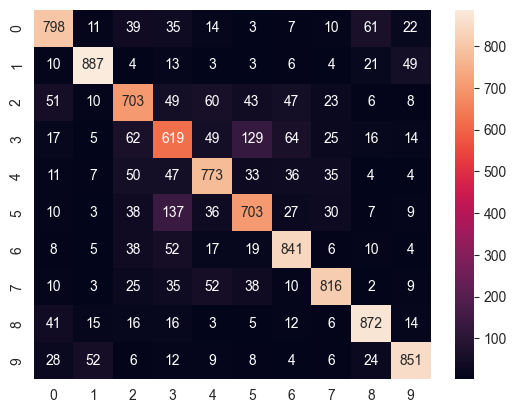

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

all_preds, all_labels = [], []
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()